In [1]:
#!/usr/bin/python
# -*- coding:Utf-8 -*-
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import fftfreq, fft, fft2, fftshift
from scipy.signal import tukey, detrend
from scipy.interpolate import interp2d
import xarray as xr

from definitionSpectre import *

In [2]:
# Ouverture du fichiers netCDF pour GIGATL3 ou GIGATL6
exp = 'GIGATL3_Equator'
indir = '/home/durand/Documents/GIGATL/'
infile = indir+exp+'.nc'
data = xr.open_dataset(infile)

#Choix de la box pour le spectre
latMin, latMax = [-0.3 , 0.3]
lonMin, lonMax = [-40 , -00]
depth = -1000

In [3]:
#Slice data box
data = data.sel(x_rho = slice(lonMin,lonMax), y_rho = slice(latMin,latMax))
data = data.sel(z_rho = depth,method = "nearest")

### Resolution
dx = data['x_rho'].diff("x_rho").mean().values*111000
dt = data['time'].diff("time").mean().values.astype('timedelta64[s]').astype(np.float32)

fx = 1./dx
ft = 1./dt

#Calcul du spectre
Fsp=[]

u=data.uCart.values
v=data.vCart.values

for y_ind in range(u.shape[1]):
    nt,nx = u[:,y_ind,:].shape
    mt,mx = v[:,y_ind,:].shape

    w,kx, Spu = compute_2d_spectrum(u[:,y_ind,:],nt,nx,dt,dx)
    w ,kx , Spv = compute_2d_spectrum(v[:,y_ind,:],mt,mx,dt,dx)
    
    Fsp.append(Spv*0+Spu)

Fsp = np.max(np.array(Fsp),0)

In [4]:
# dispersion relations dimensionalisée
B=2.3e-11
# modes2 = xr.open_dataset('/home/durand/Documents/GIGATL/relationDispersion/lambda.nc')

In [5]:
def plot_dimensional_dispR(M_modes,N_modes,kx,w,Fsp):
    """
    Plot dispersion relation as a function of vertical modes
    n=[1,..,N_modes]
    """
    oneday=86400
    onedeg=111000
    D=True
#     k=np.linspace(-5e-6,5e-6,np.shape(kx)[0])
    k = kx
    
    f,ax1 = plt.subplots(figsize=(14,12)) 
    for n in range(0,N_modes):
        omega_Y=yanai_relation(k,n,dim=D)
        omega_K=kelvin_relation(k,n,dim=D)
        if n==1:
            lb=1
        else:
            lb=1

        for m in range(1,M_modes):      
            omega_R=rossby_relation(k,m,n ,dim=D)
            omega_G=gravity_relation(k,m,n,dim=D)
            if m==1:
                lp='-'
            else:
                lp='--'
            ax1.plot(k,omega_R,color='y',lw=lb,ls=lp)
            ax1.plot(k,omega_G,color='r',lw=lb,ls=lp)

        ax1.plot(k,omega_K, color='g',lw=lb)
        ax1.plot(k,omega_Y, color='k',lw=lb)
       
    OMEGA,KX = np.meshgrid(w,kx)
    cax = ax1.contourf(-KX,OMEGA,Fsp.T*1e-10,cmap=plt.cm.jet,levels = 52,vmax = 3.,vmin = 0, extend='max')
#     cax = ax1.contourf(-KX,OMEGA,np.log10(Fsp.T/Fsp.max()),cmap=plt.cm.jet)
    
    cbar = plt.colorbar(cax)
    
    ax1.set_xlim(-.52e-5,.52e-5)
    ax1.set_ylim(0.,1e-6)
    ax1.grid('on')

    ax1.tick_params(labelsize=15)

    ax1.set_xlabel("k "+r"[$m^{-1}$]",size=15)
    ax1.set_ylabel(r"$\omega$ "+r"[$s^{-1}$]",size=15)   

    def xtick_function(r): return np.round(1./r)
    def ytick_function(r): return np.round(1./r)

    # points corresponding to experiments

#     ax1.scatter(-1./(975*1000),1./(34*86400),s=150,color='y',zorder=20)
#     plt.text(-1./(1025*1000),1./(33*86400),"$A_{k_1}$",fontsize=16)

    f.tight_layout()
    
    plt.show(block=True)

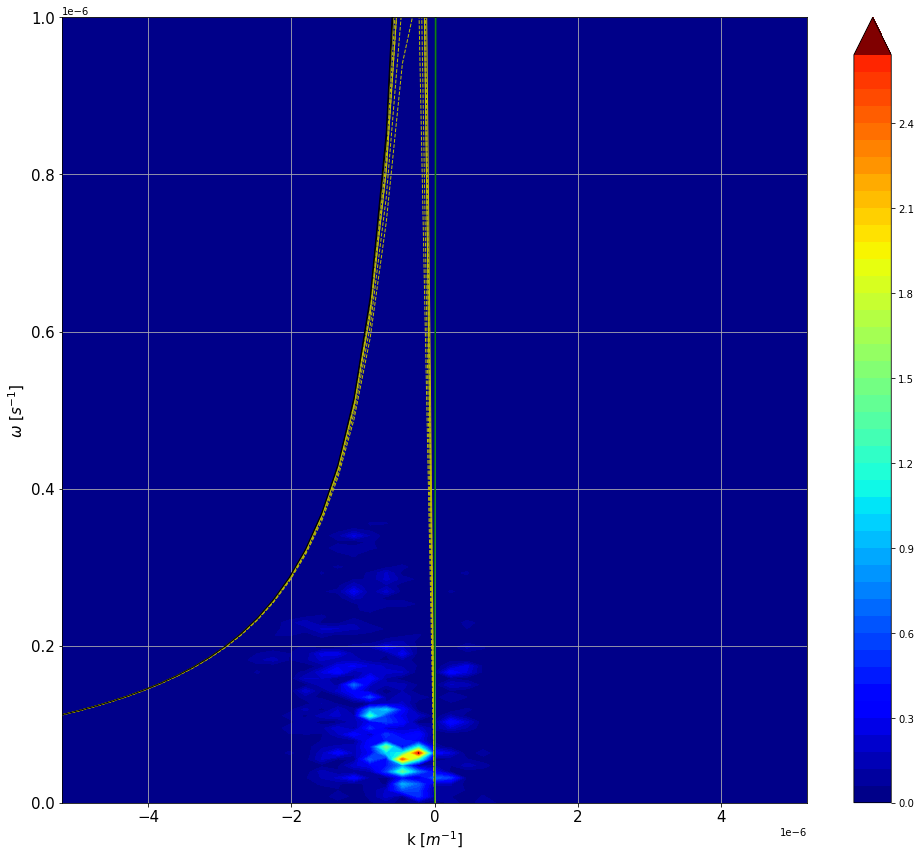

In [6]:
plot_dimensional_dispR(4,2,kx,w,Fsp)
